In [1]:
import sys, os
import pandas as pd
import pathSetting

sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")

from Clust.clust.ML.common.common import p1_integratedDataSaving as p1
from Clust.clust.ML.common.common import p2_dataSelection as p2
from Clust.clust.ML.common.common import p3_training as p3

# 2. Training 

## 2-1. Data selection

In [2]:
LearningMode = "train"
cleanParamList =["Clean", "NoClean"]
datasetNameList=['Hs1SwineFarmWithWeatherTime', 'gunwiStrawberryWithWeatherTime', 'strawberryOpenTime']

DataMeta = p1.readJsonData(pathSetting.DataMetaPath)

In [3]:
### 1-1. Change Variables#########################################################################
datasetName = datasetNameList[0]
cleanMode = cleanParamList[1]
#################################################################################################

In [17]:
datasetName

'Hs1SwineFarmWithWeatherTime'

In [4]:
dataName = LearningMode+cleanMode+'_'+datasetName
dataSaveMode = DataMeta[dataName]["integrationInfo"]["DataSaveMode"]
print(dataName)

data = p2.getSavedIntegratedData(dataSaveMode, dataName, pathSetting.dataFolderPath)
integration_freq_sec = DataMeta[dataName]["integrationInfo"]["integration_freq_sec"]

# Data Preparation Parameters
print(data.columns)
featureList= ['Temperature', 'out_temp','sin_hour']# 'sin_hour' 할 수 있도록 DB/MS 조절해야함
target_col = 'Temperature'
scalerParam='scale'
scaleMethod ='robust'

# cleanMode == Clean 일 때만 활성화
NaNProcessingParam ={
    "feature_cycle":'Day',
    "feature_cycle_times":1,
    "NanInfoForCleanData":{'type':'num', 'ConsecutiveNanLimit':3, 'totalNaNLimit':30000}
}
splitRatio = 0.8

scalerRootPath = os.path.join(pathSetting.scalerRootDir, dataName, cleanMode)
train, val, scalerFilePath = p3.getTrainValData(data, featureList, scalerRootPath, splitRatio, scalerParam, scaleMethod)
print(len(train), len(val))
print(train[[target_col]].tail())
train, val = p3.deleteLowQualityTrainValidationData(train, val, cleanMode, integration_freq_sec, NaNProcessingParam)
print(len(train), len(val))
print(train[[target_col]].tail())

# 해당 코드를 보면, 끝이 다릅니다. Cycle로 데이터 처리하면서 뒷부분을 날려버리는거 같아요 왜죠?

trainNoClean_Hs1SwineFarmWithWeatherTime
Index(['CO2ppm', 'H2Sppm', 'Humidity', 'NH3ppm', 'Temperature', 'out_humid',
       'out_pressure', 'out_rainfall', 'out_sunshine', 'out_temp',
       'out_wind_direction', 'out_wind_speed', 'cos_day_of_week', 'cos_hour',
       'cos_month', 'cos_week_of_year', 'sin_day_of_week', 'sin_hour',
       'sin_month', 'sin_week_of_year'],
      dtype='object')
['Temperature', 'out_temp', 'sin_hour']
Make New scaler File
8516 2129
                           Temperature
datetime                              
2021-03-02 13:15:00+00:00     0.120172
2021-03-02 13:20:00+00:00     0.107296
2021-03-02 13:25:00+00:00     0.107296
2021-03-02 13:30:00+00:00     0.120172
2021-03-02 13:35:00+00:00     0.120172
------ {'feature_cycle': 'Day', 'feature_cycle_times': 1, 'NanInfoForCleanData': {'type': 'num', 'ConsecutiveNanLimit': 3, 'totalNaNLimit': 30000}}
8516 2129
                           Temperature
datetime                              
2021-03-02 13:15:00+00:

<AxesSubplot:xlabel='datetime'>

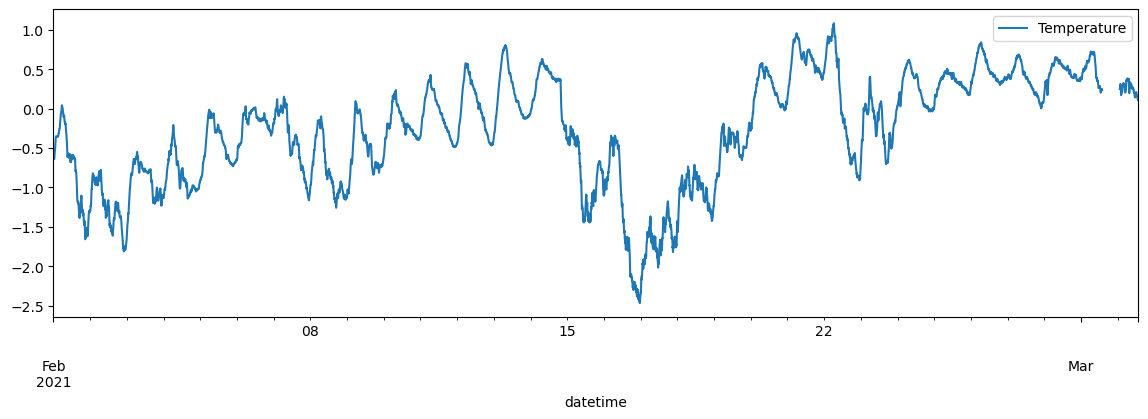

In [5]:
train[[target_col]].plot()

<AxesSubplot:xlabel='datetime'>

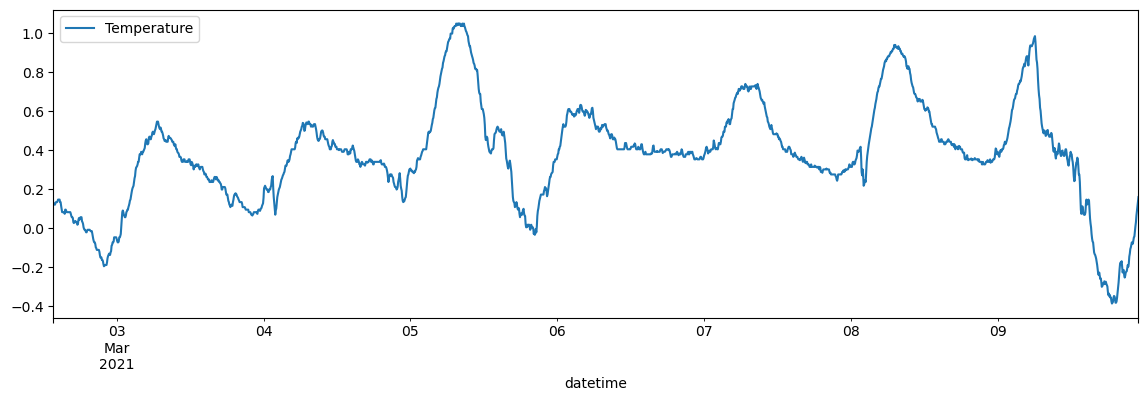

In [6]:
val[[target_col]].plot()

In [7]:
model_method ="gru"
batch_size = 64
n_epochs= 10

trainParameter = {'input_dim': len(featureList),
                'hidden_dim' : 256,
                'layer_dim' : 3,
                'output_dim' : 1,
                'dropout_prob' : 0.2}

transformParameter ={
    "future_step": 2,# 0~x
    "past_step":24,# 1~y
    "feature_col": featureList,
    "target_col":target_col 
}   
modelTags =["farm", "HS2", "prediction"]
trainDataType = "timeseries"
modelPurpose = "forecasting"

# 2
trainDataInfo = DataMeta[dataName]['integrationInfo']

# 3. 모델 파일 패스를 생성한다.
#ModelName = encodeHashStyle(p1.getListMerge ([model_method, cleanMode, trainParameter_encode, dataName] ))
ModelName = dataName+'_'+model_method

from Clust.clust.transformation.general.dataScaler import encodeHashStyle
transformParameter_encode =  encodeHashStyle(str(transformParameter))
trainDataPathList = [dataName, transformParameter_encode]

from Clust.clust.ML.common import model_manager
modelFilePath = model_manager.get_model_file_path(trainDataPathList, model_method)
# modelFilePath = p3.getModelFilePath(trainDataPathList, model_method)

./Models/gru/trainNoClean_Hs1SwineFarmWithWeatherTime/825a1196dda25f71929140240c251257/model_state_dict.pkl


cpu is available.
1. Original Data Lenagh: 8514
2. Removed Data Length: 0
3. Clean Data Leangth: 8491
1. Original Data Lenagh: 2127
2. Removed Data Length: 0
3. Clean Data Leangth: 2104
features shape: torch.Size([8491, 24, 3]) targets shape:  torch.Size([8491, 1])
features shape: torch.Size([2104, 24, 3]) targets shape:  torch.Size([2104, 1])
[1/10] Training loss: 0.0960	 Validation loss: 0.0200
[2/10] Training loss: 0.0262	 Validation loss: 0.0021
[3/10] Training loss: 0.0154	 Validation loss: 0.0023
[4/10] Training loss: 0.0193	 Validation loss: 0.0030
[5/10] Training loss: 0.0156	 Validation loss: 0.0015
[6/10] Training loss: 0.0157	 Validation loss: 0.0016
[7/10] Training loss: 0.0231	 Validation loss: 0.0015
[8/10] Training loss: 0.0199	 Validation loss: 0.0018
[9/10] Training loss: 0.0218	 Validation loss: 0.0018
[10/10] Training loss: 0.0242	 Validation loss: 0.0017


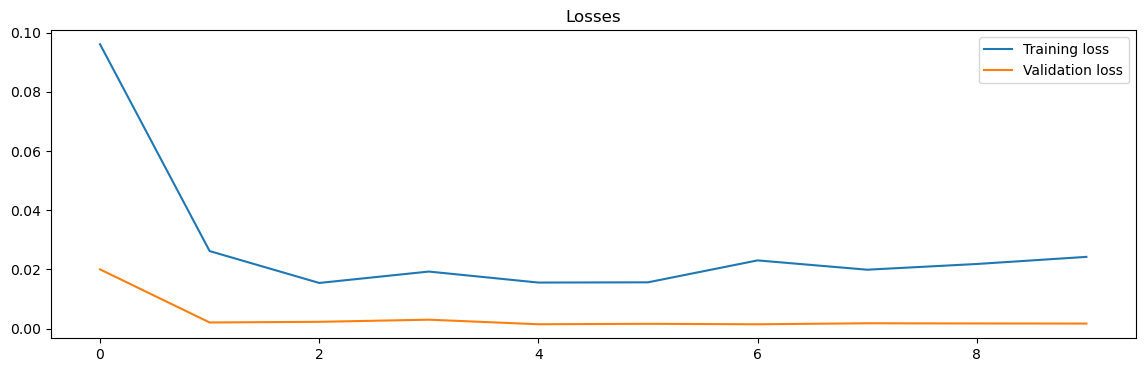

In [8]:
# 4. Training
param = {
    "clean_param":cleanMode,
    "transform_parameter":transformParameter,
    "batch_size":batch_size,
    "train_parameter":trainParameter,
    "n_epochs":n_epochs
}

from Clust.clust.ML.forecasting.train import ForecastingTrain
Ftrain= ForecastingTrain()

Ftrain.set_param(param)
Ftrain.set_data(train, val)
Ftrain.set_model(model_method)
model = Ftrain.train()


# RM.processInputData(train, val, transformParameter, cleanMode, batch_size)

# RM.setTrainParameter(trainParameter)
# RM.getModel(model_method)
# RM.trainModel(n_epochs)

In [9]:
from Clust.clust.ML.common import model_manager

model_manager.save_pickle_model(model)

In [10]:
from Clust.clust.ingestion.mongo import mongoClient as mongo_Client
from Clust.setting import influx_setting_KETI as ins
mongo_client = mongo_Client.mongoClient(ins.CLUSTMetaInfo2)

In [18]:
# 5. update MetaFile
from Clust.clust.transformation.general.dataScaler import encodeHashStyle
trainParameter_encode =  encodeHashStyle(str(trainParameter))
modelInfoMeta ={
    "trainDataInfo":trainDataInfo,
    "modelName":ModelName,
    "featureList":transformParameter["feature_col"],
    "trainDataType":trainDataType,
    "modelPurpose":modelPurpose,
    "model_method":model_method,
    "modelTags":modelTags,
    "cleanTrainDataParam":cleanMode,
    "NaNProcessingParam":NaNProcessingParam,
    "trainDataName":datasetName,
    "transformParameter":transformParameter,
    "NaNProcessingParam":NaNProcessingParam,
    "scalerParam":scalerParam,
    "files":{
        "modelFile":{
            "fileName":"model.pth",
            "filePath":modelFilePath
        },
        "scalerFile":{
            "fileName":"scaler.pkl",
            "filePath":scalerFilePath       
        }
    },
    "trainParameter":trainParameter

}
# modelInfoMeta1 = p3.updateModelMetaData(ModelName, modelInfoMeta, pathSetting.trainModelMetaFilePath)

modelInfoMeta2 = model_manager.update_model_meta_data(mongo_client, modelInfoMeta)


Success
{'trainDataInfo': {'startTime': '2021-02-01 00:00:00', 'endTime': '2021-03-10 00:00:00', 'dataInfo': [['farm_swine_air', 'HS2'], ['weather_outdoor_keti_clean', 'sangju'], ['life_additional_Info', 'trigonometicInfoByHours']], 'processParam': {'refine_param': {'removeDuplication': {'flag': False}, 'staticFrequency': {'flag': False, 'frequency': None}}, 'outlier_param': {'certainErrorToNaN': {'flag': False}, 'unCertainErrorToNaN': {'flag': False, 'param': {}}}, 'imputation_param': {'flag': False, 'imputation_method': [], 'totalNonNanRatio': 80}}, 'integration_freq_sec': 300, 'cleanParam': 'NoClean', 'DataSaveMode': 'CSV'}, 'modelName': 'trainNoClean_Hs1SwineFarmWithWeatherTime_gru', 'featureList': ['Temperature', 'out_temp', 'sin_hour'], 'trainDataType': 'timeseries', 'modelPurpose': 'forecasting', 'model_method': 'gru', 'modelTags': ['farm', 'HS2', 'prediction'], 'cleanTrainDataParam': 'NoClean', 'NaNProcessingParam': {'feature_cycle': 'Day', 'feature_cycle_times': 1, 'NanInfoFor

In [16]:
modelInfoMeta2